# Team M - Part 1

# Imports

In [ ]:
# !pip install -r requirements.txt

In [ ]:
import os
import kagglehub
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from tqdm import tqdm
import requests
import time
from tqdm import tqdm
import re
from collections import Counter
from wordcloud import WordCloud
import torch

ModuleNotFoundError: No module named 'wordcloud'

# Constants

In [ ]:
RUN_MAP_VIZUALIZATION = True

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
torch.amp.autocast('cuda')   # FP16
torch.backends.cudnn.benchmark = True

# Data Loading

In [4]:
data_path = kagglehub.dataset_download("datatattle/covid-19-nlp-text-classification")
print("Path to dataset files:", data_path)

Path to dataset files: C:\Users\MotiM\.cache\kagglehub\datasets\datatattle\covid-19-nlp-text-classification\versions\1


In [5]:
train_df = pd.read_csv(os.path.join(data_path, "Corona_NLP_train.csv"), encoding="latin1")
test_df = pd.read_csv(os.path.join(data_path, "Corona_NLP_test.csv"), encoding="latin1")

### Basic exploration

In [6]:
print("The dimensions of the datasets are:", train_df.shape, test_df.shape)

The dimensions of the datasets are: (41157, 6) (3798, 6)


In [7]:
train_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [8]:
train_df.dtypes

UserName          int64
ScreenName        int64
Location         object
TweetAt          object
OriginalTweet    object
Sentiment        object
dtype: object

In [9]:
train_df['Sentiment'] = train_df['Sentiment'].astype('category')

Null count

In [10]:
train_df.isna().sum()

UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

Seems that only location has null values. So, for visualizations involving location, we'll remove them.

Number of unique classes:

In [11]:
train_df['Sentiment'].value_counts()

Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

In [13]:
df=train_df.copy()

In [14]:
df['text_length'] = df['OriginalTweet'].apply(lambda x: len(x.split()))
print(df['text_length'].describe())

count    41157.000000
mean        30.500304
std         11.591172
min          1.000000
25%         21.000000
50%         32.000000
75%         40.000000
max         64.000000
Name: text_length, dtype: float64


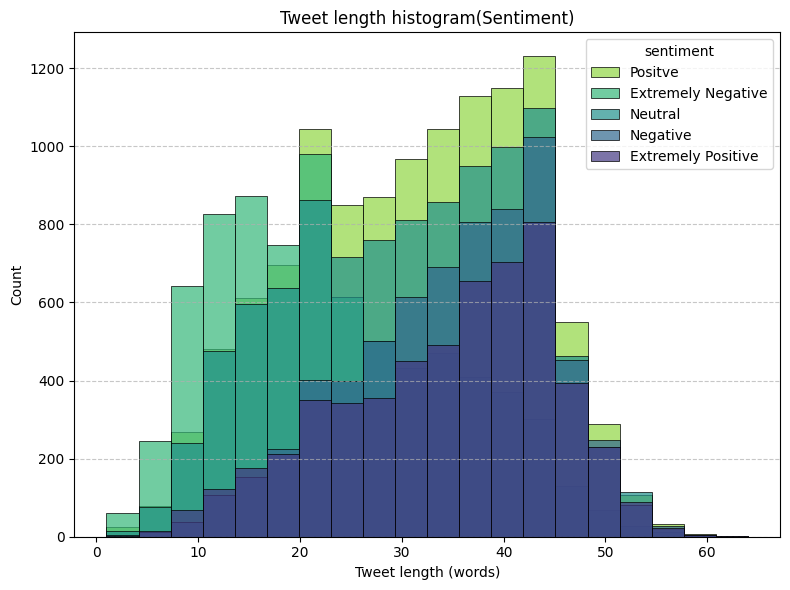

In [17]:
plt.figure(figsize=(8, 6))
sns.histplot(
    data=df, x='text_length',hue='Sentiment',bins=20, 
    multiple='layer',stat='count', palette='viridis', alpha=0.7, edgecolor='black', linewidth=0.5)

plt.title('Tweet length histogram(Sentiment)')
plt.xlabel('Tweet length (words)')
plt.ylabel('Count') 
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='sentiment', labels=['Positve','Extremely Negative','Neutral','Negative','Extremely Positive'])
plt.tight_layout()
plt.show()

In [18]:
sentiment_counts = train_df['Sentiment'].value_counts().reset_index()
sentiment_counts.columns = ['Sentiment', 'Count']
fig = px.pie(sentiment_counts, values='Count', names='Sentiment', title='Distribution of Sentiments in Training Data', hole=0.4)
fig.show()

5 classes, seems quite balanced, if we see a bias towords the classes "positive" and "negative" we will have to consider weighted loss approch.
All in all, seems like the sentiment were not leaning toward negative emotions. on the contrary, there are more positive sentiment tweets than negative.

# Visualizations

## 1. Sentiment VS Geographical location

Clean dataframe for visualiations regarding location

In [19]:
SENTIMENT_TO_SCORE_MAPPING = {
    'Extremely Negative': -2,
    'Negative': -1,
    'Neutral': 0,
    'Positive': 1,
    'Extremely Positive': 2
    }

In [ ]:
if RUN_MAP_VIZUALIZATION:
    location_viz_df = train_df[~train_df["Location"].isna()]
    location_viz_df["sentiment_score"] = location_viz_df["Sentiment"].map(SENTIMENT_TO_SCORE_MAPPING)

C:\Users\MotiM\AppData\Local\Temp\ipykernel_14088\474962109.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [23]:
LOCATION_IQ_TOKEN = 'pk.141e2e5711ccfbe2bea40ef7e857c721'
SAMPLE_SIZE = 500 # because of a rate limit to the API - maximum 5K / day - so limit to 500.

In [ ]:
if RUN_MAP_VIZUALIZATION:
    map_viz_df = location_viz_df.sample(SAMPLE_SIZE, random_state=23)

Extrapolate long, lat coordinates

In [27]:
def geocode_locationiq(location):
    url = "https://us1.locationiq.com/v1/search.php"
    params = {
        "key": LOCATION_IQ_TOKEN,
        "q": location,
        "format": "json"
    }
    try:
        response = requests.get(url, params=params)
        response.raise_for_status()
        data = response.json()
        if isinstance(data, list) and data:
            return float(data[0]['lat']), float(data[0]['lon'])
        else:
            return None, None
    except Exception as e:
        print(f"Error geocoding {location}: {e}")
        return None, None

if RUN_MAP_VIZUALIZATION:
    results = []
    for loc in tqdm(map_viz_df['Location']):
        lat, lon = geocode_locationiq(loc)
        results.append((lat, lon))
        time.sleep(0.5)  # Needed throttle (LocationIQ free tier = 2 req/sec)
    map_viz_df[['latitude', 'longitude']] = pd.DataFrame(results, index=map_viz_df.index)



  8%|▊         | 39/500 [00:33<06:28,  1.19it/s]

Error geocoding ?????: 404 Client Error: Not Found for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=%3F%3F%3F%3F%3F&format=json


 14%|█▍        | 69/500 [00:58<06:03,  1.18it/s]

Error geocoding Here and there: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Here+and+there&format=json


 14%|█▍        | 70/500 [00:59<05:59,  1.20it/s]

Error geocoding Germany: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Germany&format=json


 14%|█▍        | 71/500 [00:59<05:53,  1.21it/s]

Error geocoding Troy, MI: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Troy%2C+MI&format=json


 14%|█▍        | 72/500 [01:00<05:43,  1.25it/s]

Error geocoding Southampton: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Southampton&format=json


 15%|█▍        | 73/500 [01:01<05:31,  1.29it/s]

Error geocoding Serbia: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Serbia&format=json


 15%|█▍        | 74/500 [01:02<05:25,  1.31it/s]

Error geocoding Ankara: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Ankara&format=json


 15%|█▌        | 75/500 [01:02<05:20,  1.33it/s]

Error geocoding KC-LIMA: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=KC-LIMA&format=json


 19%|█▉        | 95/500 [01:24<05:29,  1.23it/s]

Error geocoding www.fucktrump.com: 404 Client Error: Not Found for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=www.fucktrump.com&format=json


 22%|██▏       | 110/500 [01:36<05:04,  1.28it/s]

Error geocoding Argadahana: 404 Client Error: Not Found for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Argadahana&format=json


 24%|██▍       | 120/500 [01:45<05:38,  1.12it/s]

Error geocoding ??: 404 Client Error: Not Found for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=%3F%3F&format=json


 27%|██▋       | 136/500 [01:58<05:07,  1.18it/s]

Error geocoding Georgia, USA: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Georgia%2C+USA&format=json


 27%|██▋       | 137/500 [01:59<05:03,  1.20it/s]

Error geocoding Leeds  |  Burton  |  UK: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Leeds++%7C++Burton++%7C++UK&format=json


 28%|██▊       | 138/500 [02:00<05:02,  1.20it/s]

Error geocoding Montgomery County, MD: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Montgomery+County%2C+MD&format=json


 28%|██▊       | 139/500 [02:01<04:52,  1.24it/s]

Error geocoding India: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=India&format=json


 28%|██▊       | 140/500 [02:01<04:41,  1.28it/s]

Error geocoding Brisbane, Queensland: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Brisbane%2C+Queensland&format=json


 28%|██▊       | 141/500 [02:02<04:40,  1.28it/s]

Error geocoding PUNE: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=PUNE&format=json


 28%|██▊       | 142/500 [02:03<04:43,  1.26it/s]

Error geocoding Malawi: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Malawi&format=json


 29%|██▊       | 143/500 [02:04<04:45,  1.25it/s]

Error geocoding New York, NY: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=New+York%2C+NY&format=json


 29%|██▉       | 144/500 [02:05<04:34,  1.30it/s]

Error geocoding New York, NY: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=New+York%2C+NY&format=json


 29%|██▉       | 145/500 [02:05<04:27,  1.33it/s]

Error geocoding Australia: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Australia&format=json


 29%|██▉       | 146/500 [02:06<04:22,  1.35it/s]

Error geocoding Paris: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Paris&format=json


 29%|██▉       | 147/500 [02:07<04:20,  1.35it/s]

Error geocoding News & Bible verses USA: 404 Client Error: Not Found for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=News+%26+Bible+verses+USA&format=json


 31%|███       | 154/500 [02:13<04:51,  1.19it/s]

Error geocoding deep in cognitive dissonance: 404 Client Error: Not Found for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=deep+in+cognitive+dissonance&format=json


 32%|███▏      | 162/500 [02:19<04:27,  1.26it/s]

Error geocoding Retweet doesnÂt = endorsement: 404 Client Error: Not Found for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Retweet+doesn%C3%82%C2%92t+%3D+endorsement&format=json


 36%|███▌      | 179/500 [02:33<04:26,  1.21it/s]

Error geocoding Try Ur Luck...Guess: 404 Client Error: Not Found for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Try+Ur+Luck...Guess&format=json


 41%|████▏     | 207/500 [02:57<03:55,  1.24it/s]

Error geocoding Dubai: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Dubai&format=json


 42%|████▏     | 208/500 [02:58<03:56,  1.23it/s]

Error geocoding Fort Smith, AR: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Fort+Smith%2C+AR&format=json


 42%|████▏     | 209/500 [02:58<03:48,  1.27it/s]

Error geocoding Loughborough, England: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Loughborough%2C+England&format=json


 42%|████▏     | 210/500 [02:59<03:42,  1.31it/s]

Error geocoding California, USA: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=California%2C+USA&format=json


 42%|████▏     | 211/500 [03:00<03:38,  1.33it/s]

Error geocoding Marawi City, Autonomous Region Of Muslim Mindanao: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Marawi+City%2C+Autonomous+Region+Of+Muslim+Mindanao&format=json


 42%|████▏     | 212/500 [03:01<03:40,  1.30it/s]

Error geocoding Wichita Falls,Texas: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Wichita+Falls%2CTexas&format=json


 43%|████▎     | 213/500 [03:01<03:44,  1.28it/s]

Error geocoding Crenshaw X Slauson Ave = The District: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Crenshaw+X+Slauson+Ave+%3D+The+District&format=json


 43%|████▎     | 214/500 [03:02<03:48,  1.25it/s]

Error geocoding New South Wales, Australia: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=New+South+Wales%2C+Australia&format=json


 44%|████▍     | 221/500 [03:13<04:56,  1.06s/it]

Error geocoding @literary.libations on Instagr: 404 Client Error: Not Found for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=%40literary.libations+on+Instagr&format=json


 48%|████▊     | 242/500 [03:30<03:23,  1.26it/s]

Error geocoding Playing Cool Games Since ATARI: 404 Client Error: Not Found for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Playing+Cool+Games+Since+ATARI&format=json


 49%|████▉     | 244/500 [03:32<03:40,  1.16it/s]

Error geocoding info@aptitudeconsulting.co.za: 404 Client Error: Not Found for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=info%40aptitudeconsulting.co.za&format=json


 49%|████▉     | 245/500 [03:32<03:34,  1.19it/s]

Error geocoding WestMonster: 404 Client Error: Not Found for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=WestMonster&format=json


 52%|█████▏    | 260/500 [03:45<03:20,  1.20it/s]

Error geocoding Planeptune: 404 Client Error: Not Found for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Planeptune&format=json


 55%|█████▌    | 275/500 [03:57<03:02,  1.23it/s]

Error geocoding United States: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=United+States&format=json


 55%|█████▌    | 276/500 [03:58<02:55,  1.28it/s]

Error geocoding Cardiff, Wales: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Cardiff%2C+Wales&format=json


 55%|█████▌    | 277/500 [03:58<02:50,  1.31it/s]

Error geocoding Ottawa, ON: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Ottawa%2C+ON&format=json


 56%|█████▌    | 278/500 [03:59<02:51,  1.30it/s]

Error geocoding Follow Dance Studio & Arts: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Follow+Dance+Studio+%26+Arts&format=json


 56%|█████▌    | 279/500 [04:00<02:54,  1.26it/s]

Error geocoding Colorado Springs: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Colorado+Springs&format=json


 56%|█████▌    | 280/500 [04:01<02:50,  1.29it/s]

Error geocoding Arizona, USA: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Arizona%2C+USA&format=json


 56%|█████▌    | 281/500 [04:02<02:50,  1.29it/s]

Error geocoding Durban, South Africa: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Durban%2C+South+Africa&format=json


 56%|█████▋    | 282/500 [04:02<02:46,  1.31it/s]

Error geocoding Poway, CA: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Poway%2C+CA&format=json


 57%|█████▋    | 283/500 [04:03<02:49,  1.28it/s]

Error geocoding nowhere in particular: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=nowhere+in+particular&format=json


 57%|█████▋    | 284/500 [04:04<02:50,  1.27it/s]

Error geocoding Singapore: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Singapore&format=json


 57%|█████▋    | 285/500 [04:05<02:45,  1.30it/s]

Error geocoding Pasadena, CA: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Pasadena%2C+CA&format=json


 57%|█████▋    | 286/500 [04:05<02:40,  1.34it/s]

Error geocoding 1021|Msawuden : 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=1021%7CMsawuden+&format=json


 57%|█████▋    | 287/500 [04:06<02:36,  1.36it/s]

Error geocoding New York, NY: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=New+York%2C+NY&format=json


 60%|█████▉    | 299/500 [04:17<03:13,  1.04it/s]

Error geocoding ????????: 404 Client Error: Not Found for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=%3F%3F%3F%3F%3F%3F%3F%3F&format=json


 66%|██████▌   | 328/500 [04:41<02:21,  1.22it/s]

Error geocoding Hollyweird, CA: 404 Client Error: Not Found for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Hollyweird%2C+CA&format=json


 70%|██████▉   | 348/500 [04:57<02:05,  1.21it/s]

Error geocoding WANA/Arab region: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=WANA%2FArab+region&format=json


 70%|██████▉   | 349/500 [04:58<01:59,  1.26it/s]

Error geocoding Onitsha, Nigeria: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Onitsha%2C+Nigeria&format=json


 70%|███████   | 350/500 [04:58<01:55,  1.30it/s]

Error geocoding Lenasia South, JHB: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Lenasia+South%2C+JHB&format=json


 70%|███████   | 351/500 [04:59<01:59,  1.25it/s]

Error geocoding Bournemouth, England: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Bournemouth%2C+England&format=json


 70%|███████   | 352/500 [05:00<02:03,  1.20it/s]

Error geocoding Wichita, KS: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Wichita%2C+KS&format=json


 71%|███████   | 353/500 [05:01<02:01,  1.21it/s]

Error geocoding ????She/Her ? Global: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=%3F%3F%3F%3FShe%2FHer+%3F+Global&format=json


 71%|███████   | 354/500 [05:02<01:56,  1.26it/s]

Error geocoding SF Bay Area & the OC: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=SF+Bay+Area+%26+the+OC&format=json


 71%|███████   | 355/500 [05:02<01:52,  1.29it/s]

Error geocoding CumiÃ¨res-le-Mort-Homme, France: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Cumi%C3%83%C2%A8res-le-Mort-Homme%2C+France&format=json


 73%|███████▎  | 367/500 [05:17<01:54,  1.16it/s]

Error geocoding #TheGreenPibble: 404 Client Error: Not Found for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=%23TheGreenPibble&format=json


 83%|████████▎ | 416/500 [05:57<01:04,  1.29it/s]

Error geocoding Berne, Switzerland: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Berne%2C+Switzerland&format=json


 83%|████████▎ | 417/500 [05:58<01:03,  1.31it/s]

Error geocoding Kenya: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Kenya&format=json


 84%|████████▎ | 418/500 [05:59<01:04,  1.28it/s]

Error geocoding Vancouver, BC, Canada: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Vancouver%2C+BC%2C+Canada&format=json


 84%|████████▍ | 419/500 [06:00<01:07,  1.20it/s]

Error geocoding Edmonton: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Edmonton&format=json


 84%|████████▍ | 420/500 [06:01<01:04,  1.23it/s]

Error geocoding Cleveland, Ohio: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Cleveland%2C+Ohio&format=json


 84%|████████▍ | 421/500 [06:01<01:01,  1.28it/s]

Error geocoding Leicester, England: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Leicester%2C+England&format=json


 84%|████████▍ | 422/500 [06:02<00:59,  1.30it/s]

Error geocoding Cape Cod, MA: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Cape+Cod%2C+MA&format=json


 85%|████████▍ | 423/500 [06:03<00:57,  1.33it/s]

Error geocoding Methuen, Mass.: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Methuen%2C+Mass.&format=json


 85%|████████▍ | 424/500 [06:04<00:58,  1.31it/s]

Error geocoding AmazonBooks: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=AmazonBooks&format=json


 85%|████████▌ | 425/500 [06:04<00:58,  1.29it/s]

Error geocoding Devon, England: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Devon%2C+England&format=json


 85%|████████▌ | 426/500 [06:05<00:59,  1.25it/s]

Error geocoding West Midlands: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=West+Midlands&format=json


 85%|████████▌ | 427/500 [06:06<00:58,  1.25it/s]

Error geocoding Williamsport, MD: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Williamsport%2C+MD&format=json


 98%|█████████▊| 488/500 [06:55<00:09,  1.22it/s]

Error geocoding Hyderabad: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Hyderabad&format=json


 98%|█████████▊| 489/500 [06:55<00:08,  1.26it/s]

Error geocoding email Dan@630wpro.com: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=email+Dan%40630wpro.com&format=json


 98%|█████████▊| 490/500 [06:56<00:07,  1.28it/s]

Error geocoding Toronto, Ontario: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Toronto%2C+Ontario&format=json


 98%|█████████▊| 491/500 [06:57<00:06,  1.30it/s]

Error geocoding Virtually Everywhere: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Virtually+Everywhere&format=json


 98%|█████████▊| 492/500 [06:58<00:06,  1.32it/s]

Error geocoding Philippines: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Philippines&format=json


 99%|█████████▊| 493/500 [06:58<00:05,  1.34it/s]

Error geocoding Denver, CO: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Denver%2C+CO&format=json


 99%|█████████▉| 494/500 [06:59<00:04,  1.35it/s]

Error geocoding Hackney: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Hackney&format=json


 99%|█████████▉| 495/500 [07:00<00:03,  1.32it/s]

Error geocoding London: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=London&format=json


 99%|█████████▉| 496/500 [07:01<00:03,  1.23it/s]

Error geocoding Hyderabad : 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Hyderabad+&format=json


 99%|█████████▉| 497/500 [07:02<00:02,  1.27it/s]

Error geocoding Warwick: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=Warwick&format=json


100%|█████████▉| 498/500 [07:02<00:01,  1.31it/s]

Error geocoding London, England: 429 Client Error: Too Many Requests for url: https://us1.locationiq.com/v1/search.php?key=pk.141e2e5711ccfbe2bea40ef7e857c721&q=London%2C+England&format=json


100%|██████████| 500/500 [07:09<00:00,  1.16it/s]


Plot on map

In [30]:
if RUN_MAP_VIZUALIZATION:
    agg_df = map_viz_df.groupby(['latitude', 'longitude'], as_index=False)['sentiment_score'].sum()
    fig = px.density_mapbox(
        map_viz_df,
        lat="latitude",
        lon="longitude",
        z="sentiment_score",
        radius=25,
        center={"lat": 30, "lon": 0},
        zoom=1,
        mapbox_style="carto-positron"
    )
    fig.show()

C:\Users\MotiM\AppData\Local\Temp\ipykernel_14088\2415151948.py:2: FutureWarning:

Dropping invalid columns in DataFrameGroupBy.add is deprecated. In a future version, a TypeError will be raised. Before calling .add, select only columns which should be valid for the function.



## 2. Sentiment accross dates:
Total sentiment score per day

In [31]:
timeline_sentiment_df = train_df.copy()
timeline_sentiment_df = timeline_sentiment_df[["TweetAt", "Sentiment"]]

In [32]:
timeline_sentiment_df['TweetAt'] = pd.to_datetime(timeline_sentiment_df['TweetAt'], format='%d-%m-%Y')
heatmap_data = (
    timeline_sentiment_df.groupby([timeline_sentiment_df['TweetAt'], 'Sentiment'])
    .size()
    .reset_index(name='count')
)
heatmap_pivot = heatmap_data.pivot(index='Sentiment', columns='TweetAt', values='count').fillna(0)
heatmap_pivot = heatmap_pivot.loc[sorted(heatmap_pivot.index, key=lambda s: SENTIMENT_TO_SCORE_MAPPING[s])]

fig = px.imshow(
    heatmap_pivot,
    labels=dict(x="Date", y="Sentiment Score", color="Tweet Count"),
    x=[col.strftime('%Y-%m-%d') for col in heatmap_pivot.columns],
    y=heatmap_pivot.index,
    color_continuous_scale='YlOrRd',
    aspect='auto')
fig.update_layout(
    title="Sentiment Frequency Over Time",
    xaxis_title="Date",
    yaxis_title="Sentiment",
    height=400
)
fig.show()

## 3. Word-cloud per Sentiment

In [33]:
word_cloud_df = train_df[["OriginalTweet", "Sentiment"]]

In [34]:
word_cloud_df.head()

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


C:\Users\MotiM\AppData\Local\Temp\ipykernel_14088\3681069121.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\MotiM\AppData\Local\Temp\ipykernel_14088\3681069121.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



NameError: name 'WordCloud' is not defined

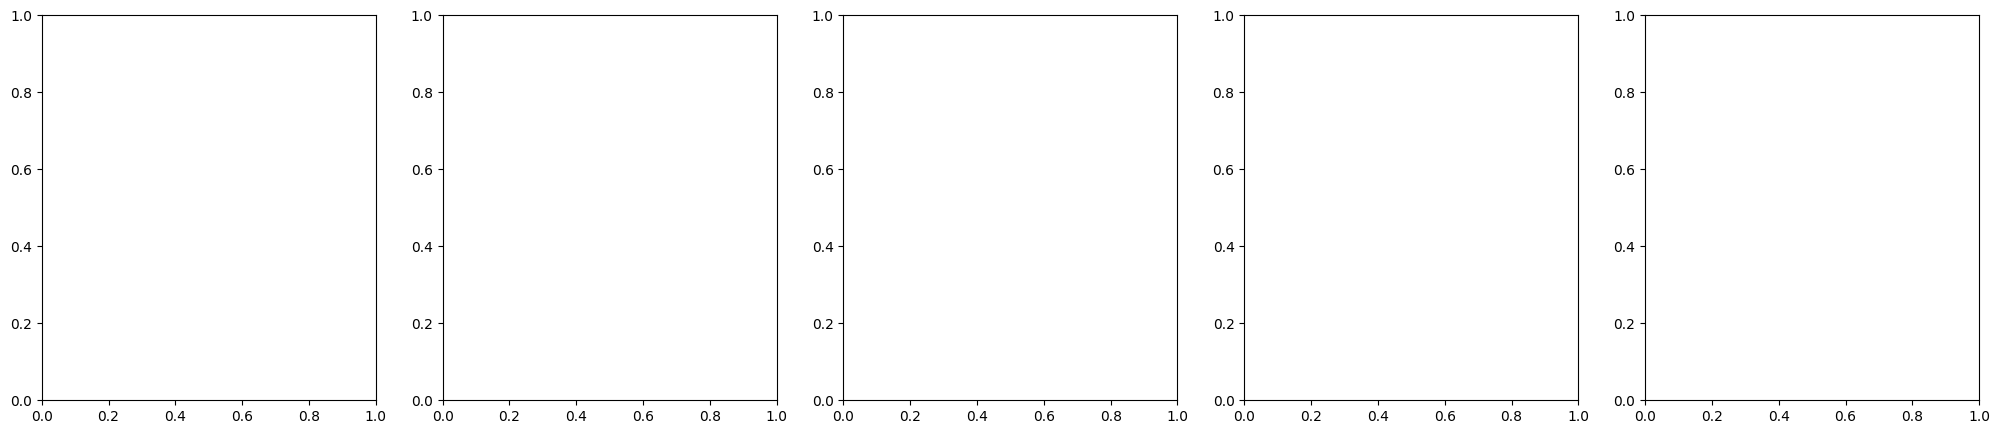

In [ ]:
word_cloud_df['clean_text'] = word_cloud_df['OriginalTweet'].str.lower()
sentiments = word_cloud_df['Sentiment'].unique()
to_remove = "http"

def delete_words_with_http(text, to_remove):
    if not isinstance(text, str):
        return text
    words = text.split()
    kept_words = [word for word in words if to_remove not in word]
    return ' '.join(kept_words)

word_cloud_df['clean_text'] = word_cloud_df['clean_text'].apply(lambda x: delete_words_with_http(x, to_remove))

# Plot word clouds
fig, axs = plt.subplots(1, len(sentiments), figsize=(5 * len(sentiments), 5))
if len(sentiments) == 1:
    axs = [axs]  # make iterable
for i, sentiment in enumerate(sentiments):
    text_blob = " ".join(word_cloud_df[word_cloud_df['Sentiment'] == sentiment]['clean_text'])
    wordcloud = WordCloud(width=400, height=400, background_color='white', colormap='viridis').generate(text_blob)
    axs[i].imshow(wordcloud, interpolation='bilinear')
    axs[i].set_title(sentiment, fontsize=16)
    axs[i].axis('off')

plt.tight_layout()
plt.show()

The word cloud **did not show** any substantial differances between the topics of tweets under all sentiment categories

Let's dive into the tweets themselves

## 4. Hashtags vs Sentiment

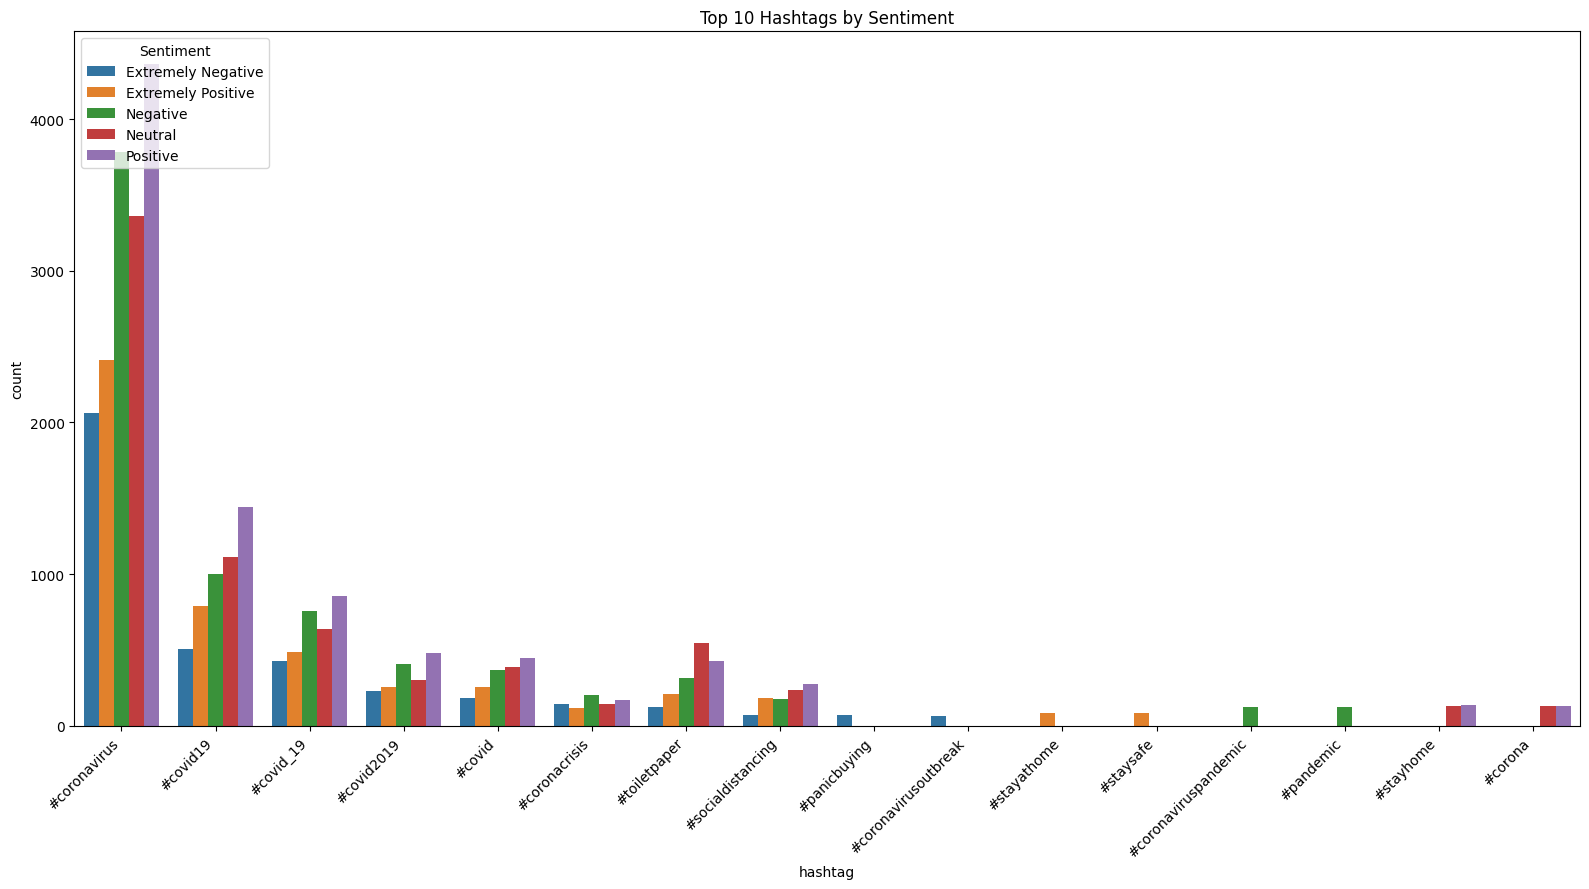

In [44]:
def extract_hashtags(text):
    return re.findall(r"#\w+", text.lower())

def build_hashtag_df(df):
    rows = []
    for _, row in df.iterrows():
        hashtags = extract_hashtags(row['OriginalTweet'])
        for tag in hashtags:
            rows.append({'Sentiment': row['Sentiment'], 'hashtag': tag})
    return pd.DataFrame(rows)

def plot_top_hashtags_by_sentiment(df, top_n = 10):
    hashtag_df = build_hashtag_df(df)
    top_tags = (
        hashtag_df
        .groupby('Sentiment')['hashtag']
        .apply(lambda x: Counter(x).most_common(top_n))
        .reset_index(name='top_hashtags')
    )
    flat_data = []
    for _, row in top_tags.iterrows():
        for tag, count in row['top_hashtags']:
            flat_data.append({'Sentiment': row['Sentiment'], 'hashtag': tag, 'count': count})

    top_df = pd.DataFrame(flat_data)
    plt.figure(figsize=(16,9))
    sns.barplot(data=top_df, x='hashtag', y='count', hue='Sentiment')
    plt.xticks(rotation=45, ha='right')
    plt.title(f'Top {top_n} Hashtags by Sentiment')
    plt.tight_layout()
    plt.show()

plot_top_hashtags_by_sentiment(train_df)

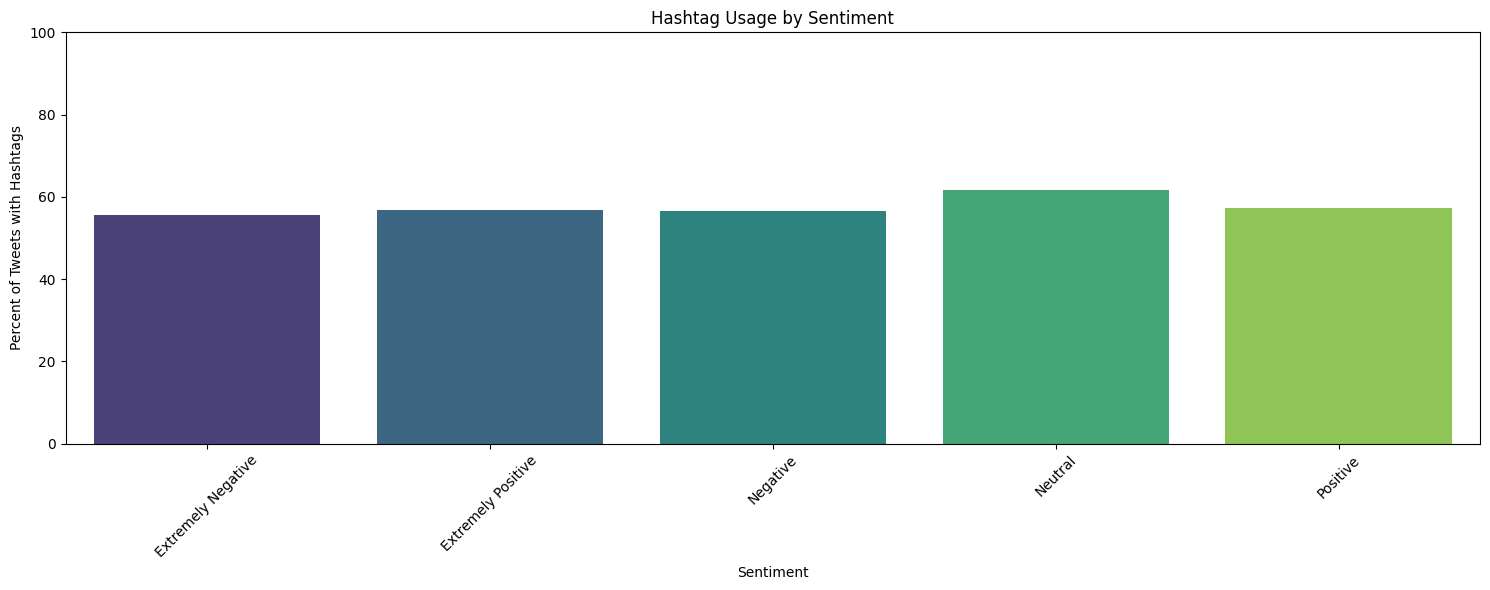

In [45]:
def has_hashtag(text):
    return bool(re.search(r"#\w+", str(text)))

hashtag_df = train_df.copy()
hashtag_df['has_hashtag'] = hashtag_df['OriginalTweet'].apply(has_hashtag)
grouped = hashtag_df.groupby('Sentiment')['has_hashtag'].agg(['sum', 'count']).reset_index()
grouped['percent_with_hashtag'] = 100 * grouped['sum'] / grouped['count']

grouped = grouped.sort_values('percent_with_hashtag', ascending=False)

# Plot
plt.figure(figsize=(15, 6))
sns.barplot(data=grouped, x='Sentiment', y='percent_with_hashtag', palette='viridis')
plt.ylabel("Percent of Tweets with Hashtags")
plt.xlabel("Sentiment")
plt.title("Hashtag Usage by Sentiment")
plt.ylim(0, 100)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Text pre processing

Since the task is LLM-based, we do not want to preform classical text processing operations like lematization and stemming, since this is encoded in the Model's tokenizer. Instead, we want to transfer the tweets to be as close to regular english (the better the model understans it and has a token representation for the word, the better).<<br>Thus, we preform the followin transformation using Regular expression: the motivation behind each step is mentioned:

In [46]:
import html

In [47]:
def clean_tweet_text(text: str) -> str:
    # Decode HTML entities
    text = html.unescape(text)
    # Replace URLs with <URL> token
    text = re.sub(r'http\S+|www\S+', '<URL>', text)
    # Replace mentions with <USER> token: none of the usernames are relevant for context and were probably anonimized.
    text = re.sub(r'@\w+', '<USER>', text)
    # Optionally remove hashtag symbol but keep the word ( #covid -> covid )
    text = re.sub(r'#(\w+)', r'\1', text)
    # Normalize excessive repeated characters (e.g., sooooo → soo), also double or tripple spaces are a waste of tokens.
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)
    # Remove leading/trailing whitespace and normalize internal spaces
    text = text.strip()
    text = re.sub(r'\s+', ' ', text)
    return text


In [48]:
clean_text_train_df = train_df.copy()
clean_text_train_df["ProcessedTweet"] = clean_text_train_df["OriginalTweet"].apply(lambda x: clean_tweet_text(x))

In [43]:
clean_text_train_df[["OriginalTweet", "ProcessedTweet"]]

,OriginalTweet,ProcessedTweet
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,<USER> <USER> <USER> <URL> and <URL> and <URL>
1,advice Talk to your neighbours family to excha...,advice Talk to your neighbours family to excha...
2,Coronavirus Australia: Woolworths to give elde...,Coronavirus Australia: Woolworths to give elde...
3,My food stock is not the only one which is emp...,My food stock is not the only one which is emp...
4,"Me, ready to go at supermarket during the #COV...","Me, ready to go at supermarket during the COVI..."
...,...,...
41152,Airline pilots offering to stock supermarket s...,Airline pilots offering to stock supermarket s...
41153,Response to complaint not provided citing COVI...,Response to complaint not provided citing COVI...
41154,You know itÂs getting tough when @KameronWild...,You know itÂs getting tough when <USER> is ra...
41155,Is it wrong that the smell of hand sanitizer i...,Is it wrong that the smell of hand sanitizer i...
